In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


%matplotlib inline  

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from BE_plotting import*
#from RR_lyrae_params import*
from blazhko_analysis import*

## Importing data

The first step is to import the `LINEAR` and `ZTF` data, as well as the data calculated in the previous notebook.

In [5]:
#| code-fold: false
# DATA
dataLINEAR = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library
end = 'ffinal'

# DATA from previous notebook
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_ffinal.csv")
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

### Plotting a light curve as an example

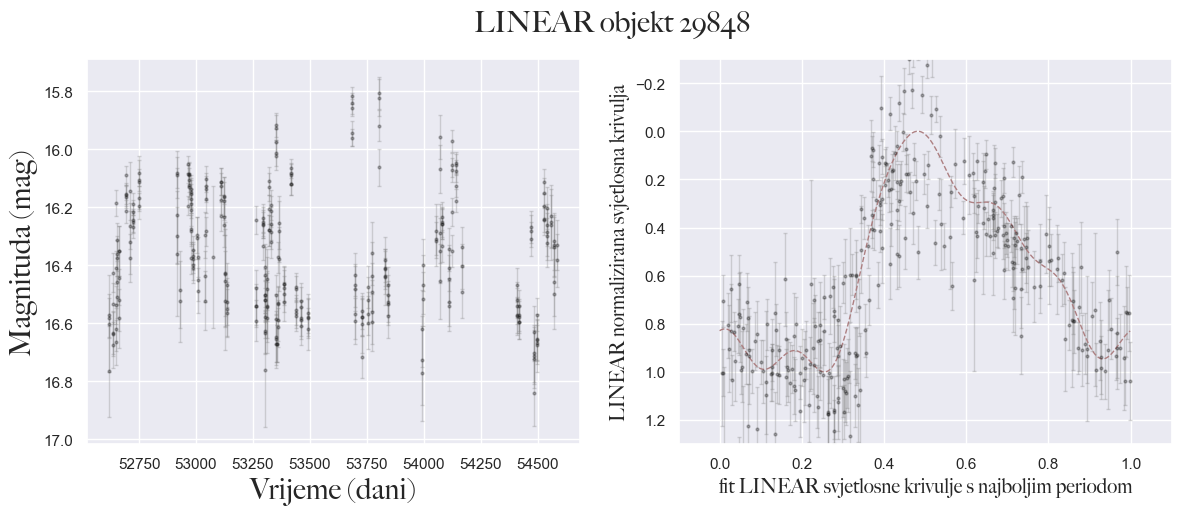

In [7]:
order = 0
LiNeAr_ids = lc_analysis['LINEAR id'].to_numpy()
total_num = len(lc_analysis['LINEAR id'].to_numpy())
Lid = LiNeAr_ids[order]
lc_data_order = dataLINEAR.get_light_curve(Lid)
time, mag, magerr = lc_data_order.T
for n, j in enumerate(fits):
    if j[0]==Lid:
        break

L1 = fits[n][1][0]

fig, ax = plt.subplots(1,2, figsize=(14,5))   
#fig.suptitle('STAR '+str(order+1)+' from '+str(total_num), fontsize=30, fontproperties=font)
fig.set_facecolor('white')

#--------
ax[0].errorbar(time, mag, magerr, fmt='.k', ecolor='gray',lw=1, ms=4, capsize=1.5,alpha=0.3)
ax[0].set_xlabel('Vrijeme (dani)',fontproperties=font)
ax[0].set_ylabel('Magnituda (mag)', fontproperties=font)
fig.suptitle('LINEAR objekt {0}'.format(Lid), fontproperties=font)
ax[0].invert_yaxis()

# -----

ax[1].set_xlabel('fit LINEAR svjetlosne krivulje s najboljim periodom', fontproperties=font, fontsize=14)
ax[1].set_ylabel('LINEAR normalizirana svjetlosna krivulja', fontproperties=font, fontsize=14)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
ax[1].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
# fit for Plinear
ax[1].plot(L1['modelPhaseGrid'], L1['modTemplate'], pink, markeredgecolor=pink, lw=1, fillstyle='top', linestyle='dashed')

plt.savefig("../images/primjer_svkrivulje_sve.png", dpi=600)

In [6]:
lc_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,LCType
0,50402,0.643303,0.643294,0.643298,0.999986,284,0.105976,0.6,0.7,0.105770,...,1.9160,295.8580,0.0149,2.2053,0.10,0.00001,NaN,NaN,NaN,1
1,62892,0.530776,0.530785,0.530780,1.000017,276,0.108535,1.1,0.9,0.114347,...,1.9434,16.8265,0.0291,4.9825,0.20,0.00002,NaN,NaN,NaN,1
2,136668,0.532923,0.532929,0.532926,1.000011,310,0.123066,1.6,1.1,0.120480,...,1.9396,15.8403,0.0801,8.7778,0.15,0.00001,NaN,NaN,NaN,1
3,141414,0.335690,0.335669,0.335680,0.999937,278,0.119125,0.6,0.8,0.158905,...,1.4928,306.2787,0.0211,4.7280,0.10,0.00006,NaN,NaN,NaN,2
4,142794,0.470787,0.470802,0.470794,1.000032,270,0.095003,1.8,1.0,0.096680,...,2.1851,16.3626,0.0286,6.0733,0.00,0.00003,NaN,NaN,NaN,1


# Determination of BE candidates

(write up entire explanation of the algorithm)

In [23]:
blazhko_can = pd.DataFrame(())
blazhko_can = blazhko_determine(lc_analysis, blazhko_can)
blazhko_can.to_csv("../outputs/blazhko_can"+end+".csv", index=False)

In [24]:
blazhko_can = pd.read_csv("../outputs/blazhko_can"+end+".csv")

In [25]:
blazhko_can.shape

(243, 40)

# Determining vallidity of BE candidates

In order to make visual interpretation easier and more robust, we are dividing our BE candidates into smaller tables. The categories are:
- LINEAR periodogram parameter satisfied
- ZTF periodogram parameter satisfied
- Chi2 parameter satisfied
    - ZTF Chi2 parameter
    - LINEAR Chi2 parameter

The last three are based on the `ChiType` for determining LINEAR or ZTF parameter satisfaction. The periodogram parameter is determined by the `IndicatorType` column.

# Visual inspection of every category

In [10]:
be_other = blazhko_can[(blazhko_can['IndicatorType']!= 'Z') & (blazhko_can['IndicatorType']!= 'L')&(blazhko_can['ChiType']!='Z')&(blazhko_can['ChiType']!='L')]
be_other = be_other.reset_index(drop=True)
print(be_other.shape)
be_other.head()

(175, 39)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,3149365,0.739189,0.546732,0.642960,0.739638,315,0.116789,0.4,0.7,0.811264,...,1.8327,277.3925,0.0196,9.1540,0.29,0.29933,NaN,NaN,6.0,period
1,5222353,0.339503,0.650435,0.494969,1.915845,577,0.211803,1.3,0.9,1.317427,...,1.6066,14.4707,0.0813,2.2430,0.34,0.62818,NaN,NaN,6.0,period
2,10598277,0.632047,0.275105,0.453576,0.435260,422,0.054255,6.5,1.4,0.815854,...,1.2534,23.9292,0.0613,5.8564,0.41,0.78695,NaN,NaN,6.0,period
3,62758,0.209055,0.651565,0.430310,3.116716,276,0.072512,1.1,1.0,0.954646,...,1.5836,20.4939,0.0872,4.7024,0.22,1.02835,NaN,NaN,6.0,period
4,92986,9.312872,0.651565,4.982218,0.069964,289,0.138932,17.7,2.0,0.222502,...,1.5836,20.4939,0.0872,4.7024,0.18,1.73844,NaN,NaN,6.0,period


In [11]:
BE_candidates_ztf_per = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataLINEAR, 'ztf_periodogram',id_list=None,parameter='IndicatorType', value='Z')

This dataset has 83 stars.


In [12]:
blazhko_analyzer = BE_candidates_ztf_per.get_save_data()
end = 'ztf_periodogram'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

In [13]:
print(blazhko_analyzer.shape)

(29, 39)


In [29]:
end = 'ztf_periodogram'
blazhko_can_ztf = pd.read_csv('../outputs/blazhko_list'+end+'.csv')

[843294,
 1736308,
 2079147,
 2276533,
 2660232,
 2669011,
 2714034,
 3196582,
 3377349,
 3666049,
 3797767,
 5549773,
 5895287,
 7580734,
 7593064,
 7997579,
 8337518,
 8595866,
 9979905,
 11366353,
 17266250,
 21126144,
 21397555,
 21460667,
 21556651,
 21874209,
 21948919,
 22571231,
 22828215]

In [ ]:
BE_candidates_ztf_per = category_analysis(blazhko_can_ztf, fits, periodogr, ztf_data, dataLINEAR, 'ztf_periodogram',id_list=None,parameter=None, value=None)

In [ ]:
blazhko_analyzer = BE_candidates_ztf_per.get_save_data()
end = 'ztf_periodogram_final'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

---

In [14]:
BE_candidates_linear_per = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataLINEAR, 'linear_periodogram',id_list=None,parameter='IndicatorType', value='L')

This dataset has 60 stars.


In [15]:
blazhko_analyzer = BE_candidates_linear_per.get_save_data()
end = 'linear_periodogram'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

In [16]:
print(blazhko_analyzer.shape)

(3, 39)


In [30]:
end = 'linear_periodogram'
blazhko_can_linearper = pd.read_csv('../outputs/blazhko_list'+end+'.csv')

[1212611, 8610884, 9852554]

In [ ]:
BE_candidates_linear_per = category_analysis(blazhko_can_linearper, fits, periodogr, ztf_data, dataLINEAR, 'ztf_periodogram',id_list=None,parameter=None, value=None)

In [ ]:
blazhko_analyzer = BE_candidates_linear_per.get_save_data()
end = 'linear_periodogram_final'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

---

In [17]:
BE_candidates_ztf_chi = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataLINEAR, 'ztf_chi',id_list=None,parameter='ChiType', value='Z')

This dataset has 53 stars.


In [18]:
blazhko_analyzer = BE_candidates_ztf_chi.get_save_data()
end = 'ztf_chi'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

In [19]:
print(blazhko_analyzer.shape)

(10, 39)


In [31]:
end = 'ztf_chi'
blazhko_can_ztfchi = pd.read_csv('../outputs/blazhko_list'+end+'.csv')

[810169,
 1092244,
 3219035,
 3589854,
 4547090,
 7411461,
 9449335,
 10420063,
 24020106,
 24192279]

In [ ]:
BE_candidates_ztf_chi = category_analysis(blazhko_can_ztfchi, fits, periodogr, ztf_data, dataLINEAR, 'ztf_periodogram',id_list=None,parameter=None, value=None)

In [ ]:
blazhko_analyzer = BE_candidates_ztf_chi.get_save_data()
end = 'ztf_chi_final'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

---

In [20]:
BE_candidates_linear_chi = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataLINEAR, 'linear_chi',id_list=None,parameter='ChiType', value='L')

This dataset has 118 stars.


In [21]:
blazhko_analyzer = BE_candidates_linear_chi.get_save_data()
end = 'linear_chi'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

In [22]:
print(blazhko_analyzer.shape)

(1, 39)


In [32]:
end = 'linear_chi'
blazhko_canlinearchi = pd.read_csv('../outputs/blazhko_list'+end+'.csv')

[61011]

In [ ]:
BE_candidates_linear_chi = category_analysis(blazhko_canlinearchi, fits, periodogr, ztf_data, dataLINEAR, 'ztf_periodogram',id_list=None,parameter=None, value=None)

In [ ]:
blazhko_analyzer = BE_candidates_linear_chi.get_save_data()
end = 'linear_chi_final'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

---

In [24]:
BE_candidates_other = category_analysis(be_other, fits, periodogr, ztf_data, dataLINEAR, 'other')

This dataset has 175 stars.


In [25]:
blazhko_analyzer = BE_candidates_other.get_save_data()
end = 'other'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

In [26]:
print(blazhko_analyzer.shape)

(2, 39)


In [33]:
end = 'other'
blazhko_can_other = pd.read_csv('../outputs/blazhko_list'+end+'.csv')

[10598277, 23708638]

In [ ]:
BE_candidates_other = category_analysis(blazhko_can_other, fits, periodogr, ztf_data, dataLINEAR, 'ztf_periodogram',id_list=None,parameter=None, value=None)

In [ ]:
blazhko_analyzer = BE_candidates_other.get_save_data()
end = 'other_final'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

---

# FINAL BLAZHKO LISTS

## ZI list

In [11]:
ZI_list = [61011, 62892,810169,1092244,1111785,1212611,1491775,1615764,1736308,2041979,2050107,3218931,3351006,3589854,3797767,
           3941776,4545362,4546177,4912051, 6022777, 7545954,7555727, 9449335, 9961135, 9979905, 10420063,10481905,10503746,10598277,
           10814742, 16494763, 18525697, 21126144, 21281847, 21379220,21874209,21947560,21948290,21948919,22244513,22571231,22639551,22828215,
           23223856,23604060,24020106,24107664]

In [12]:
len(ZI_list)

47

## EI list

In [27]:
blazhko_can.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,LCType,period_vs_amp
0,608497,0.485636,0.748671,0.617154,1.541630,556,0.080140,20.4,2.5,0.927147,...,34.1880,0.3134,6.8994,0.16,0.42621,NaN,Z,11.0,1,period
1,664583,0.602994,0.603021,0.603008,1.000045,449,0.115904,1.8,1.1,0.147908,...,116.6181,0.0639,8.6314,0.10,0.00004,Z,NaN,NaN,1,NaN
2,810169,0.465185,0.465212,0.465198,1.000058,289,0.140729,6.0,2.1,0.158269,...,13.6184,0.0364,8.6093,0.16,0.00006,NaN,Z,6.0,1,period
3,843294,0.374216,0.374214,0.374215,0.999995,290,0.123428,3.3,1.4,0.118790,...,316.9572,0.1486,11.3686,0.05,0.00001,Z,NaN,NaN,2,NaN
4,880588,0.600138,0.600134,0.600136,0.999993,295,0.110419,3.2,1.2,0.116817,...,354.6099,0.0737,12.1826,0.21,0.00001,L,NaN,NaN,1,NaN


In [13]:
EI_list = [61011, 810169, 843294, 1092244, 1212611, 1736308, 2079147, 2276533, 2669011, 2714034, 3196582, 
           3219035, 3797767, 5549773, 5895287, 7411461, 7580734, 7593064, 7997579, 
           8337518, 9449335, 9979905, 10420063, 10598277, 17266250, 21126144, 21397555, 
           21460667, 21874209, 21948919, 22571231, 24020106]

In [14]:
len(EI_list)

32

# Going over EI_list

In [15]:
BE_EI_list = category_analysis(lc_analysis, fits, periodogr, ztf_data, dataLINEAR, end='EI_list',id_list=EI_list)

This dataset has 44 stars.


In [16]:
blazhko_analyzer = BE_EI_list.get_save_data()
end = 'EI_list'
blazhko_analyzer.to_csv("../outputs/blazhko_list"+end+".csv", index=False)

In [13]:
blazhko_analyzer = pd.read_csv("../outputs/blazhko_listEI_list.csv")

#### Checking for the same IDs

In [16]:
same_id = [x for x in EI_list if x in ZI_list]
print(len(same_id))

15


In [17]:
same_id

[61011,
 810169,
 1092244,
 1212611,
 1736308,
 3797767,
 9449335,
 9979905,
 10420063,
 10598277,
 21126144,
 21874209,
 21948919,
 22571231,
 24020106]

# Creating a final catalogue

In [18]:
same_id_list = blazhko_can['LINEAR id'].isin(same_id)
SAME_BE_LIST = blazhko_can[same_id_list]
SAME_BE_LIST = SAME_BE_LIST.reset_index(drop=True)
SAME_BE_LIST['Quality flag'] = len(same_id)*[3]
SAME_BE_LIST.head()

ValueError: Length of values (15) does not match length of index (13)

In [18]:
EI_list1 = [x for x in EI_list if x not in same_id]

In [19]:
EI_be_list = blazhko_can['LINEAR id'].isin(EI_list1)
EI_BE_list = blazhko_can[EI_be_list]
EI_BE_list = EI_BE_list.reset_index(drop=True)
EI_BE_list['Quality flag'] = len(EI_list1)*[2]
EI_BE_list.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp,Quality flag
0,843294,0.374216,0.374214,0.374215,0.999995,290,0.123428,3.3,1.4,0.118790,...,316.9572,0.1486,11.3686,0.05,0.00001,Z,NaN,NaN,NaN,2
1,2079147,0.617457,0.617458,0.617458,1.000002,459,0.074148,0.9,0.8,0.073361,...,47.2367,0.0597,5.8857,0.04,0.00000,Z,NaN,NaN,NaN,2
2,2276533,0.586232,0.586234,0.586233,1.000003,322,0.084196,1.0,0.9,0.085524,...,91.9118,0.0631,5.4908,0.11,0.00000,Z,NaN,NaN,NaN,2
3,2669011,0.591153,0.591151,0.591152,0.999997,450,0.041678,2.4,1.1,0.040439,...,101.2146,0.0751,6.5360,0.16,0.00000,Z,NaN,NaN,NaN,2
4,2714034,0.610868,0.610800,0.610834,0.999889,536,0.120191,2.4,1.5,0.183835,...,302.1148,2.8246,143.2064,0.06,0.00011,Z,NaN,NaN,NaN,2


In [20]:
ZI_list1 = [x for x in ZI_list if x not in same_id]
len(ZI_list1)

32

In [21]:
ZI_list1 = [x for x in ZI_list1 if x in list(lc_analysis['LINEAR id'])]

In [22]:
ZI_be = lc_analysis['LINEAR id'].isin(ZI_list1)
ZI_be_list = lc_analysis[ZI_be]
ZI_be_list = ZI_be_list.reset_index(drop=True)
ZI_be_list['Quality flag'] = len(ZI_list1)*[1]
print(ZI_be_list.shape)
ZI_be_list.head()

(28, 39)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,Quality flag
0,62892,0.530776,0.530785,0.530780,1.000017,276,0.108535,1.1,0.9,0.114347,...,1.9434,16.8265,0.0291,4.9825,0.20,0.00002,NaN,NaN,NaN,1
1,1491775,0.785391,0.354951,0.570171,0.451942,293,0.183621,4.8,2.0,0.537780,...,2.8222,209.4241,0.0407,14.9164,0.08,0.75493,NaN,NaN,NaN,1
2,1615764,0.488189,0.488190,0.488190,1.000002,334,0.053845,3.0,1.5,0.051151,...,2.0712,43.8404,0.0504,10.5182,0.24,0.00000,NaN,NaN,NaN,1
3,2041979,0.653694,0.653639,0.653666,0.999916,276,0.134647,1.5,1.2,0.181584,...,1.5347,207.4689,0.0144,9.8341,0.30,0.00008,NaN,NaN,NaN,1
4,3218931,0.693979,0.693939,0.693959,0.999942,274,0.049901,28.8,2.6,0.049920,...,1.4460,203.6660,0.0197,8.6264,0.20,0.00006,NaN,NaN,NaN,1


### Putting it all together

In [27]:
FINAL_BE_CATALOGUE = pd.DataFrame()
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, SAME_BE_LIST.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, EI_BE_list.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, ZI_be_list.reset_index(drop=True)],ignore_index=True, axis=0)
print(FINAL_BE_CATALOGUE.shape)
FINAL_BE_CATALOGUE.head()

(60, 40)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp,Quality flag
0,61011,0.662374,0.643294,0.652834,0.971195,274,0.073564,78.9,5.1,0.845785,...,295.8580,0.0149,2.2053,0.27,0.02923,NaN,L,9.0,period,3
1,810169,0.465185,0.465212,0.465198,1.000058,289,0.140729,6.0,2.1,0.158269,...,13.6184,0.0364,8.6093,0.16,0.00006,NaN,Z,6.0,period,3
2,1092244,0.649496,0.649558,0.649527,1.000095,590,0.106827,2.3,1.2,0.158591,...,13.6482,0.0747,0.0136,0.25,0.00010,NaN,Z,6.0,period,3
3,1212611,0.630896,0.630893,0.630894,0.999995,297,0.049308,0.9,0.9,0.050812,...,18.6047,0.0264,6.5970,0.18,0.00000,L,NaN,NaN,NaN,3
4,1736308,0.555848,0.555843,0.555846,0.999991,372,0.054970,2.9,1.3,0.054586,...,36.6367,0.0529,5.6501,0.11,0.00001,Z,NaN,NaN,NaN,3


In [28]:
FINAL_BE_CATALOGUE.to_csv('../outputs/FINAL_BE_CATALOGUE.csv', index=False)

In [29]:
FINAL_BE_CATALOGUE = pd.read_csv("../outputs/FINAL_BE_CATALOGUE.csv")

In [30]:
FINAL_BE_CATALOGUE.columns

Index(['LINEAR id', 'Plinear', 'Pztf', 'Pmean', 'Pratio', 'NdataLINEAR',
       'L_rms', 'L_chi2dof', 'L_chi2dofR', 'Lmean_rms', 'Lmean_chi2dof',
       'Lmean_chi2dofR', 'Lmmax', 'Lampl', 'NdataZTF', 'Z_rms', 'Zchi2dof',
       'Zchi2dofR', 'Zmean_rms', 'Zmean_chi2dof', 'Zmean_chi2dofR', 'Zmmax',
       'Zampl', 'MainPeakL', 'BlazhkoPeakL', 'BlazhkoPeriodL', 'BpowerRatioL',
       'BsignificanceL', 'MainPeakZ', 'BlazhkoPeakZ', 'BlazhkoPeriodZ',
       'BpowerRatioZ', 'BsignificanceZ', 'Ampl_diff', 'dP', 'IndicatorType',
       'ChiType', 'BE_score', 'period_vs_amp', 'Quality flag'],
      dtype='object')

### Making a table for the paper

In [31]:
SHOWCASE_Catalogue1 = pd.DataFrame()
SHOWCASE_Catalogue1['LINEAR id'] = FINAL_BE_CATALOGUE['LINEAR id']
SHOWCASE_Catalogue1['LINEAR period'] = FINAL_BE_CATALOGUE['Plinear']
SHOWCASE_Catalogue1['ZTF period'] = FINAL_BE_CATALOGUE['Pztf']
SHOWCASE_Catalogue1['LINEAR hi-kvadrat'] = FINAL_BE_CATALOGUE['L_chi2dofR']
SHOWCASE_Catalogue1['ZTF hi-kvadrat'] = FINAL_BE_CATALOGUE['Zchi2dofR']
SHOWCASE_Catalogue1['LINEAR amplituda'] = FINAL_BE_CATALOGUE['Lampl']
SHOWCASE_Catalogue1['ZTF amplituda'] = FINAL_BE_CATALOGUE['Zampl']
SHOWCASE_Catalogue1['LINEAR glavna frekvencija'] = FINAL_BE_CATALOGUE['MainPeakL']
SHOWCASE_Catalogue1['LINEAR blazhko frekvencija'] = FINAL_BE_CATALOGUE['BlazhkoPeakL']
SHOWCASE_Catalogue1['ZTF glavna frekvencija'] = FINAL_BE_CATALOGUE['MainPeakZ']
SHOWCASE_Catalogue1['ZTF blazhko frekvencija'] = FINAL_BE_CATALOGUE['BlazhkoPeakZ']
SHOWCASE_Catalogue1['LINEAR blazhko period'] = FINAL_BE_CATALOGUE['BlazhkoPeriodL']
SHOWCASE_Catalogue1['ZTF blazhko period'] = FINAL_BE_CATALOGUE['BlazhkoPeriodZ']

In [32]:
SHOWCASE_Catalogue1.head(10)

,LINEAR id,LINEAR period,ZTF period,LINEAR hi-kvadrat,ZTF hi-kvadrat,LINEAR amplituda,ZTF amplituda,LINEAR glavna frekvencija,LINEAR blazhko frekvencija,ZTF glavna frekvencija,ZTF blazhko frekvencija,LINEAR blazhko period,ZTF blazhko period
0,61011,0.662374,0.643294,5.1,1.1,0.65,0.38,1.5097,1.5450,1.9127,1.9160,28.3849,295.8580
1,810169,0.465185,0.465212,2.1,2.5,0.77,0.61,2.1497,2.2232,2.1496,2.2230,13.6017,13.6184
2,1092244,0.649496,0.649558,1.2,2.9,0.72,0.47,1.5397,1.5735,1.5393,1.6125,29.5421,13.6482
3,1212611,0.630896,0.630893,0.9,1.1,0.75,0.57,1.5850,1.5962,1.5851,1.6388,89.3256,18.6047
4,1736308,0.555848,0.555843,1.3,1.0,0.70,0.59,1.7991,1.8330,1.7991,1.8264,29.4377,36.6367
5,3797767,0.613224,0.613213,1.5,1.7,0.64,0.53,1.6307,1.6647,0.8153,0.8248,29.4377,105.4296
6,9449335,0.475720,0.475695,2.0,3.0,0.89,0.61,2.1021,2.1359,1.0008,1.0340,29.5465,30.1023
7,9979905,0.338739,0.338739,2.5,1.8,0.46,0.37,2.9521,2.9860,1.0008,1.0255,29.5072,40.4531
8,10420063,0.487395,0.487394,4.2,3.7,0.97,0.68,2.0517,2.0857,2.0517,2.1007,29.4421,20.4207
9,10598277,0.632047,0.275105,1.4,1.1,0.64,0.23,1.5822,1.6160,1.2117,1.2534,29.5465,23.9292


In [44]:
SHOWCASE_Catalogue1.shape

(60, 11)

In [45]:
incidence_rate = SHOWCASE_Catalogue1.shape[0]/lc_analysis.shape[0]
print(f'The incidence rate of Blazhko stars in our sample of stars is:{incidence_rate*100}%')

The incidence rate of Blazhko stars in our sample of stars is:3.523194362889019%


### Plotting graphs for the paper

In [1]:
ID_list_paper = [810169]
ID_list_paper2 = [1736308]
ID_list_paper3 = [9449335]
ID_list_paper4 = [10420063]

In [55]:
single = category_analysis(lc_analysis, fits, periodogr, ztf_data, dataLINEAR, end='test',id_list=ID_list_paper, plotSave=True)

This dataset has 1 stars.
